In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN

import pandas as pd
import json
import os
import re

import pickle

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

In [2]:
# Pickle code: 


a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

# Opening Files: 

In [3]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [4]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

In [5]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

# Merging Files: 

In [6]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tech_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [7]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('T') and col[1:].isdecimal()]]

In [8]:
s_r = list(set(Y_s.columns).difference(set(Y_r.columns)))

In [9]:
r_s = list(set(Y_r.columns).difference(set(Y_s.columns)))

In [10]:
rs = list(set(Y_s.columns).intersection(set(Y_r.columns)))

<AxesSubplot:>

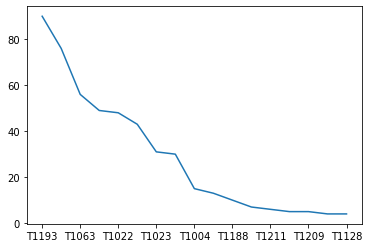

In [11]:
Y_r[r_s].sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

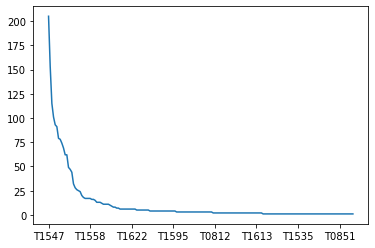

In [12]:
Y_s[s_r].sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

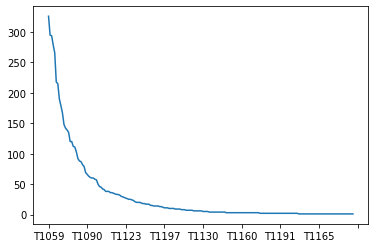

In [13]:
Y_s[rs].sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

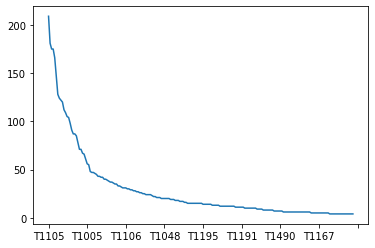

In [14]:
Y_r[rs].sum(axis=0).sort_values(ascending=False).plot()

In [15]:
Y1 = Y_s[rs]
Y1[r_s] = 0
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the techniques in Y1

<ipython-input-15-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-15-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-15-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y

In [16]:
X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(X_r, Y_r, test_size=0.3,
                                                    random_state = 10)

In [17]:
X_train_text = pd.concat([X_r_train, X_s])

In [18]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

<AxesSubplot:>

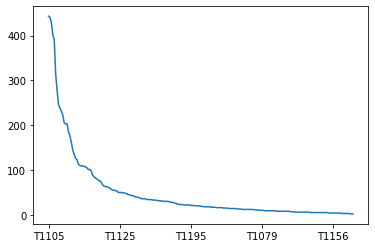

In [19]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

# Feature Selection: 

In [20]:
# ------------ Count Vectorizer --------------- 

cv = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 2, max_df = 0.99) # if words used less than 0.001 % --> ignore  

X_train = cv.fit_transform(X_train_text)

X_train = pd.DataFrame(X_train.toarray(), columns = cv.get_feature_names()) 

X_test = cv.transform(X_test_text)

X_test = pd.DataFrame(X_test.toarray(), columns = cv.get_feature_names())                 

# ---------------- TF-IDF ---------------------: 


# tf_idf = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df=2, max_df=0.99)

#X_train = tf_idf.fit_transform(X_train_text)

#X_train = pd.DataFrame(X_train.toarray(), columns=tf_idf.get_feature_names()) 

#X_test = tf_idf.transform(X_test_text)

#X_test = pd.DataFrame(X_test.toarray(), columns=tf_idf.get_feature_names()) 


# Measuring Cosine Similarity to Remove Duplicates: 

In [21]:
similarities = cosine_similarity(X_train, X_test)

In [22]:
# check if articles have a cosine similarity of more than 90%
duplicates = set() 
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            
            duplicates.add(i)

In [23]:
# remove similar articles
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

<AxesSubplot:>

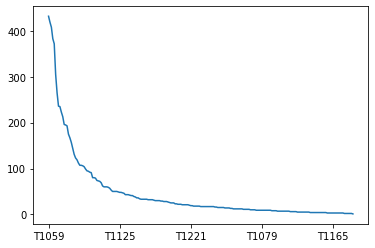

In [24]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

# Naive Bayes: 

In [25]:
# Open Pickle: 

#with open('bayes_technique.pickle', 'rb') as handle:
#    naive_bayes_classifier = pickle.load(handle)

In [26]:
naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [27]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(X_test), columns = Y_test.columns)

In [28]:
y_pred = (y_pred_proba > 0.005).astype(int) # if increase threshold, recall decreases and precision (could) increase

In [29]:
precision_score(Y_test, y_pred, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.13218115462159272

In [30]:
precision_score(Y_test, y_pred, average ='micro')

0.13599719593410445

In [31]:
fbeta_score(Y_test, y_pred, beta=0.5, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.10396597045113797

In [32]:
fbeta_score(Y_test, y_pred, beta=0.5, average ='micro')

0.1475172990647099

In [33]:
recall_score(Y_test, y_pred, average='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.15930333601287106

In [34]:
recall_score(Y_test, y_pred, average='micro')

0.22311673375503163

In [35]:
# Save as pickle: 

with open('bayes_technique.pickle', 'wb') as handle:
    pickle.dump(naive_bayes_classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)

# SVC:

In [ ]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

In [ ]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

In [ ]:
precision_score(Y_test, Y_pred, average ='macro')

In [ ]:
precision_score(Y_test, Y_pred, average ='micro')

In [ ]:
fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')

In [ ]:
fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')

In [ ]:
recall_score(Y_test, Y_pred, average='macro')

In [ ]:
recall_score(Y_test, Y_pred, average='micro')

# Multi-label KNN: 

In [ ]:
knn = MLkNN(k = 3)

In [ ]:
# train
knn.fit(X_train.values, Y_train.values)

# predict
predictions = knn.predict(X_test.values)

In [ ]:
fbeta_score(Y_test, predictions, beta=0.5, average ='macro')

In [ ]:
fbeta_score(Y_test, predictions, beta=0.5, average ='micro')

In [ ]:
precision_score(Y_test, predictions, average ='macro')

In [ ]:
precision_score(Y_test, predictions, average ='micro')

In [ ]:
recall_score(Y_test, predictions, average='macro')

In [ ]:
recall_score(Y_test, predictions, average='micro')